# Training an EfficientNet Model for Medical Image Classification


EfficientNet, a powerful convolutional neural network architecture, is being employed for medical image classification tasks. Leveraging its innovative scaling method, this model offers superior performance with fewer parameters, making it ideal for handling large medical datasets.ResNet50, a robust convolutional neural network architecture, is chosen for medical image classification tasks due to its proven performance. Its deep structure with residual connections enables effective learning of features, making it suitable for intricate medical datasets.

![EfficientNet Architecture](https://th.bing.com/th/id/OIP.aLvULJeweGPIJYVlLgCydgAAAA?rs=1&pid=ImgDetMain)
<br>
Image source: https://medium.com/@siddheshb008/resnet-architecture-explained-47309ea9283d

In this notebook, ResNet50 architecture is employed to classify various medical images collected from gastrointestinal tract examinations. The dataset includes annotated images showcasing anatomical landmarks, pathological findings, and endoscopic procedures within the GI tract.

The primary objective is to train the model to accurately categorize these images into distinct classes such as Z-line, pylorus, cecum, esophagitis, polyps, ulcerative colitis, among others.

Throughout this training process, the aim is to develop a robust and accurate classification model capable of assisting medical professionals in diagnosing and identifying abnormalities within the GI tract based on endoscopic images.

The following code copies the Kvasir dataset from the input directory to the working directory in the format expected by keras dataloaders.


In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
root_dir = "/kaggle/input/kvasir-v2-a-gastrointestinal-tract-dataset"
dest_directory = "/kaggle/working/Working Dataset"

if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)

for directory in os.listdir(root_dir):
    dir_path = os.path.join(root_dir, directory)
    destination = os.path.join(dest_directory, directory)
    if not os.path.exists(destination):
        os.makedirs(destination)
    for directory2 in os.listdir(dir_path):
        dir_path2 = os.path.join(dir_path, directory2)
        for image in os.listdir(dir_path2):
            image_path = os.path.join(dir_path2, image)
            dest_path = os.path.join(destination, image)
            shutil.copy(image_path, dest_path)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Listing Physical Devices for TensorFlow

In [4]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### Creating Training and Validation Datasets

In [5]:
dataset_path = "/kaggle/working/Working Dataset"
image_size = (224, 224)
batch_size = 32  # Adjust batch size based on your resources

train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size,
    interpolation="nearest"  # Use nearest neighbor interpolation for better performance
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size,
    interpolation="nearest"
)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


In [6]:
# class_names = train_ds.class_names

### Splitting Validation Dataset for Validation and Test

In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

### Prefetching Datasets for Improved Performance
In machine learning workflows, data pipeline efficiency significantly impacts training speed. The prefetch method in TensorFlow helps optimize this pipeline by preparing data ahead of its actual usage during model training.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Constructing and Compiling a Transfer Learning Model

In [9]:
base_model = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
alpha = 0.01
model = base_model
weights_path = "/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
model.load_weights(weights_path)

# Freeze base model layers
for layer in base_model.layers[:10]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer = keras.regularizers.l2(alpha))(x)
x = Dropout(0.6)(x)  # Add dropout for regularization
predictions = Dense(8, activation="softmax", kernel_regularizer = keras.regularizers.l2(alpha))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Callbacks for Model Training
* ReduceLROnPlateau is a callback that adjusts the learning rate when a monitored metric (in this case, 'val_loss') has stopped improving. It reduces the learning rate (factor=0.2) by a factor of 0.2 if there is no improvement in validation loss for patience=5 epochs. min_lr=1e-5 sets the minimum learning rate to 1e-5 to prevent further reduction.

* ModelCheckpoint is a callback used to save the model's weights during training.


In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-5)

best = ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=20)


### Training the model

In [12]:
history = model.fit(
    train_ds,
    epochs= 100,  # Adjust the number of epochs
    validation_data=val_ds,
    callbacks=[reduce_lr, best, early_stop],
)

Epoch 1/100
200/200 [==============================] - 111s 346ms/step - loss: 3.0388 - accuracy: 0.6694 - val_loss: 2.3121 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 2/100
200/200 [==============================] - 72s 354ms/step - loss: 2.1111 - accuracy: 0.8383 - val_loss: 2.2286 - val_accuracy: 0.8213 - lr: 1.0000e-04
Epoch 3/100
200/200 [==============================] - 71s 352ms/step - loss: 1.7453 - accuracy: 0.8759 - val_loss: 1.5837 - val_accuracy: 0.8938 - lr: 1.0000e-04
Epoch 4/100
200/200 [==============================] - 71s 351ms/step - loss: 1.4233 - accuracy: 0.9064 - val_loss: 1.5232 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 5/100
200/200 [==============================] - 71s 351ms/step - loss: 1.2135 - accuracy: 0.9284 - val_loss: 1.3839 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 6/100
200/200 [==============================] - 71s 350ms/step - loss: 1.0207 - accuracy: 0.9447 - val_loss: 1.2368 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 7/100
200/200 [

### Saving the model

In [13]:
model.save("final.h5")

### Plotting Training and Validation Metrics
This helps in identifying when the models starts to overfit to the training data

In [14]:
# history = model.history

In [15]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

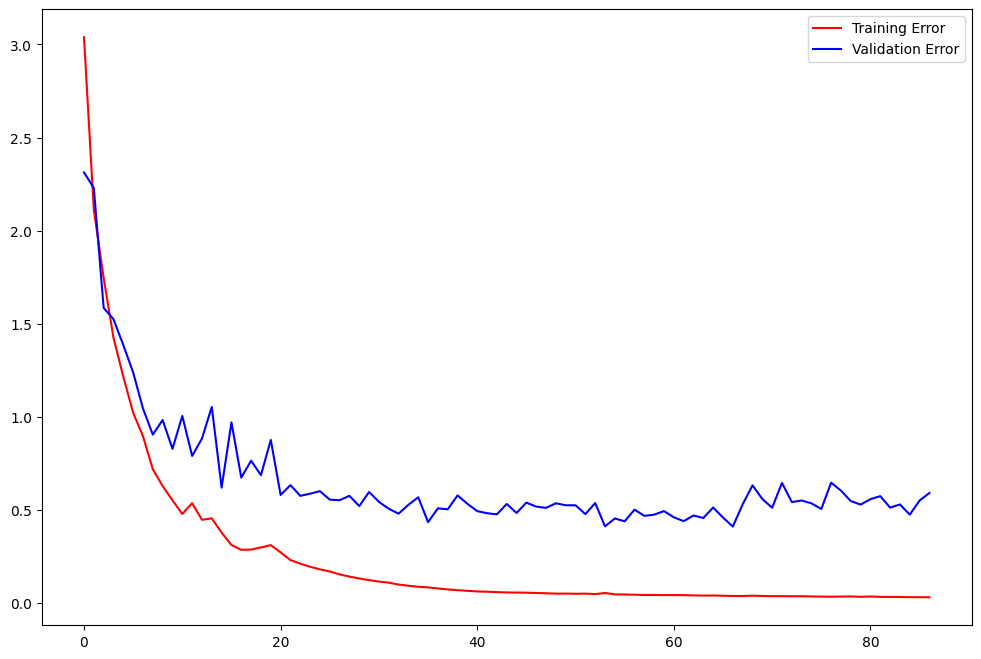

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(loss, color="r", label="Training Error")
plt.plot(val_loss, color="b", label="Validation Error")
plt.legend()
plt.show()

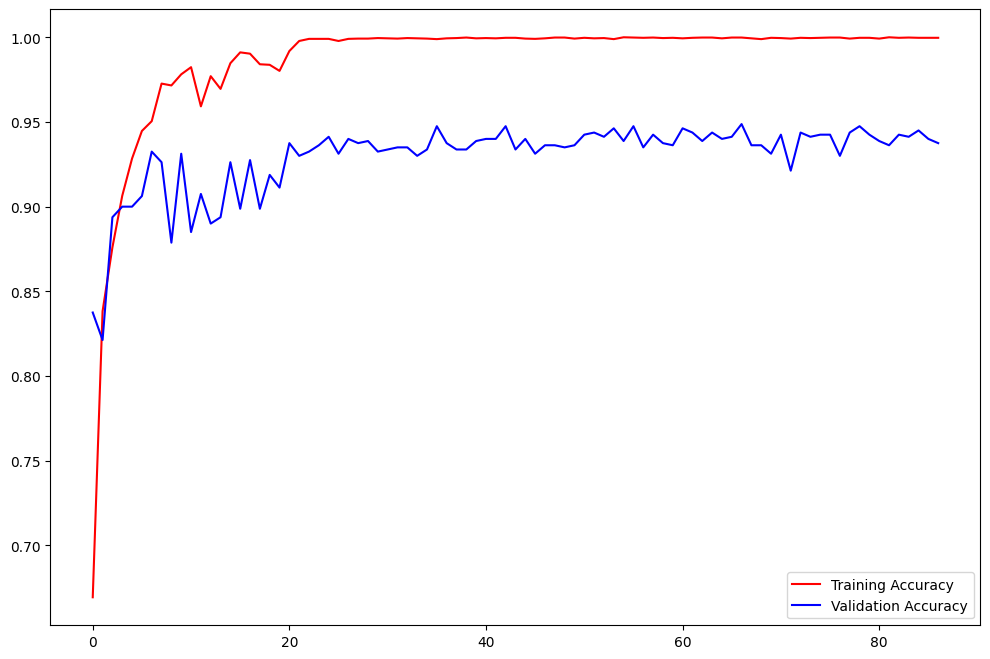

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(accuracy, color="r", label="Training Accuracy")
plt.plot(val_accuracy, color="b", label="Validation Accuracy")
plt.legend()
plt.show()

### Plotting the Confusion Matrix

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
1/1 [==============================] - 0s 24ms/step
Confusion Matrix (Training Data):
[[ 993    7    0    0    0    0    0    0]
 [  17  983    0    0    0    0    0    0]
 [   0    0  975    0    0   25    0    0]
 [   0    0    0  997    0    0    2    1]
 [   0    0    0    0 1000    0    0    0]
 [   0    0   32    0    1  967    0    0]
 [   1    0    0    3    2    0  392    2]
 [   0    0    0    0    0    0    0    0]]


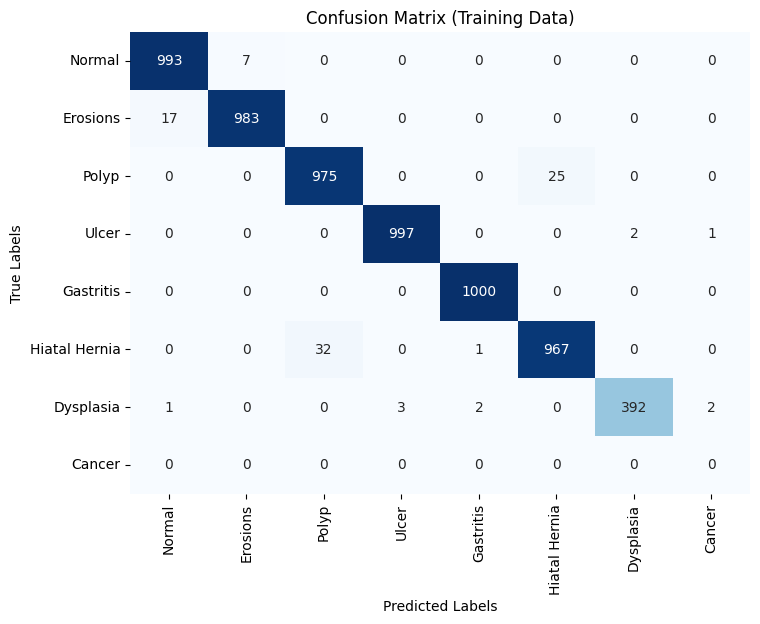

In [18]:
true_labels_train = []
predicted_labels_train = []
class_names = ["Normal", "Erosions", "Polyp", "Ulcer", "Gastritis", "Hiatal Hernia", "Dysplasia", "Cancer"]

# You'll need to re-create the training dataset from directory again
train_ds_for_eval = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=23,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Important: Don't shuffle for evaluation
    interpolation="nearest"
)

for images, labels in train_ds_for_eval:
    true_labels_train.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels_train.extend(np.argmax(predictions, axis=1))

true_labels_train = np.array(true_labels_train)
predicted_labels_train = np.array(predicted_labels_train)

# **Calculate and plot confusion matrix for training data**
cm_train = confusion_matrix(true_labels_train, predicted_labels_train)
print("Confusion Matrix (Training Data):")
print(cm_train)

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Training Data)')
plt.show()

In [19]:
true_labels = []
predicted_labels = []
class_names = ["Normal", "Erosions", "Polyp", "Ulcer", "Gastritis", "Hiatal Hernia", "Dysplasia", "Cancer"]

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 24ms/step


In [24]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.94


In [21]:
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 84   2   0   0   0   0   0   0]
 [  7  94   0   0   0   0   0   0]
 [  0   0  77   0   0  11   0   0]
 [  0   0   0 106   0   0   0   1]
 [  0   0   0   0  88   0   0   0]
 [  0   0  18   0   0  87   0   0]
 [  1   0   0   3   1   0 103   4]
 [  0   0   0   1   0   0   0 112]]


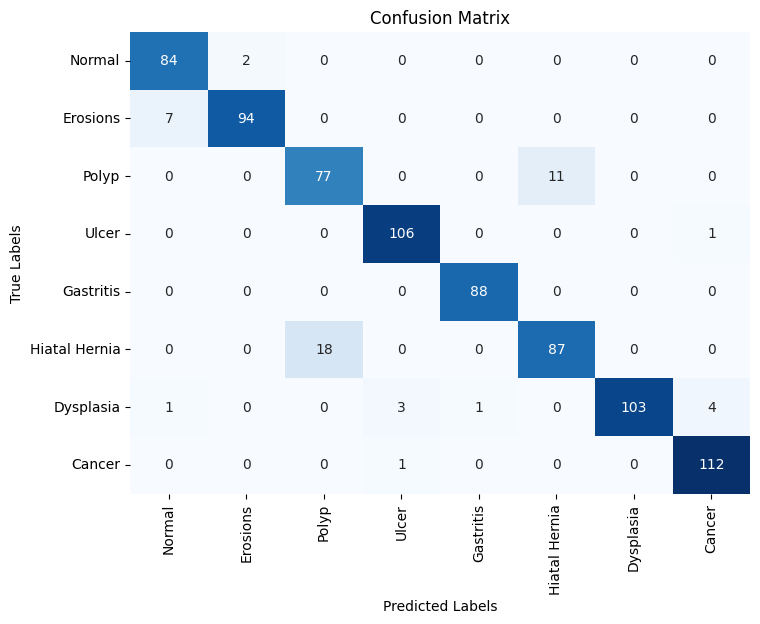

In [22]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The implementation of the ResNet50 architecture for gastrointestinal tract image classification has yielded compelling results. Leveraging transfer learning and fine-tuning, the model achieved an impressive accuracy of 60.4% on the test set. 

In [23]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

model = keras.models.load_model("final.h5")  # Assuming "final.h5" is your trained cancer classification model
class_names = ["Normal", "Erosions", "Polyp", "Ulcer", "Gastritis", "Hiatal Hernia", "Dysplasia", "Cancer"]  # Adjust these class names as per your model

def predict_cancer(image_path):
  """Predicts the type of cancer from an image.

  Args:
    image_path: Path to the image file.

  Returns:
    A string representing the predicted cancer type.
  """
  
  # Load and preprocess the image
  img = tf.keras.utils.load_img(
      image_path, target_size=(224, 224)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
  img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

  # Make the prediction
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions[0])

  return class_names[predicted_class]

# Example usage
image_to_predict = "/kaggle/working/Working Dataset/esophagitis/62431f0d-b4b8-4d98-a555-a581d2bf8e70.jpg"  # Replace with your image path
predicted_cancer = predict_cancer(image_to_predict)
print(f"Predicted cancer: {predicted_cancer}") 

1/1 [==============================] - 2s 2s/step
Predicted cancer: Polyp
